In [0]:
import tensorflow as tf
import numpy as np
import re
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [0]:
#!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
#!unzip cornell_movie_dialogs_corpus.zip

In [0]:
movie_line = "cornell movie-dialogs corpus/movie_lines.txt"
movie_convo = "cornell movie-dialogs corpus/movie_conversations.txt"

m_lines = open(movie_line , encoding='utf-8',errors='ignore').read().split('\n')
c_lines = open(movie_convo , encoding='utf-8',errors='ignore').read().split('\n')

convo_line = []
for lines in c_lines:
    _lines = lines.split(" +++$+++ ")[-1][1:-1].replace("'","").replace(" ","")
    convo_line.append(_lines.split(","))

id_line = {}
for lines in m_lines:
    _lines = lines.split(" +++$+++ ")
    if len(_lines) == 5:
        id_line[_lines[0]] = _lines[4]

questions = []
answers = []

for line in convo_line:
    for i in range(len(line) -1):
        questions.append(id_line[line[i]])
        answers.append(id_line[line[i+1]])

def clean_text(text):
    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"  ","",text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text

clean_questions = []
clean_answers = []

for q in questions:
    clean_questions.append(clean_text(q))
for a in answers:
    clean_answers.append(clean_text(a))

max_length = 5
min_length = 2

codes = ['<PAD>','<EOS>','<UNK>','<GO>']



short_questions_temp = []
short_answers_temp = []

i = 0
for question in clean_questions:
    if len(question.split()) >= min_length and len(question.split()) <= max_length:
        short_questions_temp.append(question)
        short_answers_temp.append(clean_answers[i])
    i += 1

# Filter out the answers that are too short/long
shorted_q = []
shorted_a = []

i = 0
for answer in short_answers_temp:
    if len(answer.split()) >= min_length and len(answer.split()) <= max_length:
        shorted_a.append(answer)
        shorted_q.append(short_questions_temp[i])
    i += 1
   
  

  
vocab = {}

for question in shorted_q:
    for words in question.split():
        if words not in vocab:
            vocab[words] = 1
        else:
            vocab[words] +=1
for answer in shorted_a:
    for words in answer.split():
        if words not in vocab:
            vocab[words] = 1
        else:
            vocab[words] +=1
            
questions_vocabs = {}
for answer in shorted_q:
    for words in answer.split():
        if words not in questions_vocabs:
            questions_vocabs[words] = 1
        else:
            questions_vocabs[words] +=1
            
answers_vocabs = {}
for answer in shorted_a:
    for words in answer.split():
        if words not in answers_vocabs:
            answers_vocabs[words] = 1
        else:
            answers_vocabs[words] +=1

vocabs_to_index = {}
threshold = 2
word_num = 0
for word, count in vocab.items():
    if count >= threshold:
        vocabs_to_index[word] = word_num
        word_num += 1
        

for code in codes:
    vocabs_to_index[code] = len(vocabs_to_index)+1
    
for code in codes:
    questions_vocabs[code] = len(questions_vocabs)+1

for code in codes:
    answers_vocabs[code] = len(answers_vocabs)+1

    
index_to_vocabs = {v_i: v for v, v_i in vocabs_to_index.items()}

for i in range(len(shorted_a)):
  shorted_a[i] += ' <EOS>'
  
questions_int = []
for question in shorted_q:
    ints = []
    for word in question.split():
        if word not in vocabs_to_index:
            ints.append(vocabs_to_index['<UNK>'])
        else:
            ints.append(vocabs_to_index[word])
    questions_int.append(ints)
    
answers_int = []
for answer in shorted_a:
    ints = []
    for word in answer.split():
        if word not in vocabs_to_index:
            ints.append(vocabs_to_index['<UNK>'])
        else:
            ints.append(vocabs_to_index[word])
    answers_int.append(ints)


In [4]:
for code in codes:
  print(vocabs_to_index[code])

6283
6284
6285
6286


In [0]:
target_vocab_size = len(answers_vocabs)
source_vocab_size = len(questions_vocabs)
vocab_size = len(index_to_vocabs)+1
embed_size = 128
rnn_size = 128
batch_size = 128
num_layers = 2 
learning_rate = 0.001
learning_rate_decay = 0.9
min_lr = 0.0001
#keep_prob = 0.5
epochs=500
DISPLAY_STEP=30

In [0]:
def lstm(rnn_size, keep_prob,reuse=False):
    lstm =tf.nn.rnn_cell.LSTMCell(rnn_size,reuse=reuse)
    drop =tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    return drop

In [0]:
def attention(rnn_size,encoder_outputs,target_sequence_length,dec_cell):
    attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(rnn_size*2,encoder_outputs,
                                                                   memory_sequence_length=target_sequence_length)
    attention_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell, attention_mechanism,
                                                             attention_layer_size=rnn_size/2)
    return attention_cell

In [0]:
input_data = tf.placeholder(tf.int32, [None, None],name='input')
target_data = tf.placeholder(tf.int32, [None, None],name='target')
input_data_len = tf.placeholder(tf.int32,[None],name='input_len')
target_data_len = tf.placeholder(tf.int32,[None],name='target_len')
lr_rate = tf.placeholder(tf.float32,name='lr')
keep_prob = tf.placeholder(tf.float32,name='keep_prob')

In [9]:
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size, embed_size], -1, 1))
encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, input_data)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
stacked_cells = lstm(rnn_size, keep_prob)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [11]:
((encoder_fw_outputs,encoder_bw_outputs),
 (encoder_fw_final_state,encoder_bw_final_state)) = tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked_cells, 
                                                                 cell_bw=stacked_cells, 
                                                                 inputs=encoder_embedded, 
                                                                 sequence_length=input_data_len, 
                                                                 dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
encoder_outputs = tf.concat((encoder_fw_outputs,encoder_bw_outputs),2)

In [13]:
encoder_outputs

<tf.Tensor 'concat:0' shape=(?, ?, 256) dtype=float32>

In [0]:
encoder_state_c = tf.concat((encoder_fw_final_state.c,encoder_bw_final_state.c),1)
encoder_state_h = tf.concat((encoder_fw_final_state.h,encoder_bw_final_state.h),1)
encoder_states = tf.nn.rnn_cell.LSTMStateTuple(c=encoder_state_c,h=encoder_state_h)

In [15]:
encoder_states

LSTMStateTuple(c=<tf.Tensor 'concat_1:0' shape=(?, 256) dtype=float32>, h=<tf.Tensor 'concat_2:0' shape=(?, 256) dtype=float32>)

In [0]:
main = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
decoder_input = tf.concat([tf.fill([batch_size, 1],vocabs_to_index['<GO>']), main], 1)

In [0]:
decoder_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, embed_size], -1, 1))
dec_cell_inputs = tf.nn.embedding_lookup(decoder_embeddings, decoder_input)

In [0]:
dec_cell = lstm(rnn_size*2,keep_prob)

In [19]:
dec_cell

In [0]:
dense_layer = tf.layers.Dense(target_vocab_size)

In [21]:
train_helper = tf.contrib.seq2seq.TrainingHelper(dec_cell_inputs, target_data_len)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
attention_cell = attention(rnn_size,encoder_outputs,target_data_len,dec_cell)
state = attention_cell.zero_state(dtype=tf.float32, batch_size=batch_size)
state = state.clone(cell_state=encoder_states)

In [0]:
decoder_train = tf.contrib.seq2seq.BasicDecoder(cell=attention_cell, helper=train_helper, 
                                                  initial_state=state,
                                                  output_layer=dense_layer) 

In [0]:
outputs_train, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder_train, 
                                                  impute_finished=True, 
                                                  maximum_iterations=tf.reduce_max(target_data_len))

In [0]:
infer_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(decoder_embeddings, 
                                                          tf.fill([batch_size], vocabs_to_index['<GO>']), 
                                                          vocabs_to_index['<EOS>'])

In [0]:
decoder_infer = tf.contrib.seq2seq.BasicDecoder(cell=attention_cell, helper=infer_helper, 
                                                  initial_state=state,
                                                  output_layer=dense_layer)

In [0]:
outputs_infer, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder_infer, impute_finished=True,
                                                          maximum_iterations=tf.reduce_max(target_data_len))

In [0]:
training_logits = tf.identity(outputs_train.rnn_output, name='logits')
inference_logits = tf.identity(outputs_infer.sample_id, name='predictions')

In [0]:
masks = tf.sequence_mask(target_data_len, tf.reduce_max(target_data_len), dtype=tf.float32, name='masks')

In [0]:
cost = tf.contrib.seq2seq.sequence_loss(training_logits,target_data,masks)

In [0]:
optimizer = tf.train.AdamOptimizer(lr_rate)

In [0]:
gradients = optimizer.compute_gradients(cost)
capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
train_op = optimizer.apply_gradients(capped_gradients)

In [0]:
def pad_sentence(sentence_batch, pad_int):
    padded_seqs = []
    seq_lens = []
    max_sentence_len = max([len(sentence) for sentence in sentence_batch])
    for sentence in sentence_batch:
        padded_seqs.append(sentence + [pad_int] * (max_sentence_len - len(sentence)))
        seq_lens.append(len(sentence))
    return padded_seqs, seq_lens


In [0]:
def get_accuracy(target, logits):
    max_seq = max(len(target[1]), logits.shape[1])
    if max_seq - len(target[1]):
        target = np.pad(
            target,
            [(0,0),(0,max_seq - len(target[1]))],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

In [0]:
train_data = questions_int[batch_size:]
test_data = answers_int[batch_size:]
val_train_data = questions_int[:batch_size]
val_test_data = answers_int[:batch_size]

In [36]:
len(train_data)

22992

In [0]:
pad_int = vocabs_to_index['<PAD>']

In [0]:
val_batch_x,val_batch_len = pad_sentence(val_train_data,pad_int)
val_batch_y,val_batch_len_y = pad_sentence(val_test_data,pad_int)
val_batch_x = np.array(val_batch_x)
val_batch_y = np.array(val_batch_y)

In [0]:
no_of_batches = math.floor(len(train_data)//batch_size)
round_no = no_of_batches*batch_size

In [0]:
def sentence_to_seq(sentence, vocabs_to_index):
    results = []
    for word in sentence.split(" "):
        if word in vocabs_to_index:
            results.append(vocabs_to_index[word])
        else:
            results.append(vocabs_to_index['<UNK>'])        
    return results

In [0]:
translate_sentence = 'how are you'
translate_sentence = sentence_to_seq(translate_sentence, vocabs_to_index)

In [42]:
save_path = 'model_weights'
acc_plt = []
loss_plt = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        total_accuracy = 0.0
        total_loss = 0.0
        for bs in tqdm(range(0,round_no  ,batch_size)):
          index = min(bs+batch_size, round_no )
          #print(bs,index)
      
      
          batch_x,len_x = pad_sentence(train_data[bs:index],pad_int)
          batch_y,len_y = pad_sentence(test_data[bs:index],pad_int)
      
      
          batch_x = np.array(batch_x)
          batch_y = np.array(batch_y)
          pred,loss_f,opt = sess.run([inference_logits,cost,train_op], 
                                      feed_dict={input_data:batch_x,
                                                target_data:batch_y,
                                                input_data_len:len_x,
                                                target_data_len:len_y,
                                                lr_rate:learning_rate,
                                                keep_prob:0.75})

          train_acc = get_accuracy(batch_y, pred)
          total_loss += loss_f 
          total_accuracy+=train_acc
    
        total_accuracy /= (round_no // batch_size)
    
        total_loss /=  (round_no//batch_size)
        acc_plt.append(total_accuracy)
        loss_plt.append(total_loss)
        translate_logits = sess.run(inference_logits, {input_data: [translate_sentence]*batch_size,
                                         input_data_len: [len(translate_sentence)]*batch_size,
                                         target_data_len: [len(translate_sentence)]*batch_size,              
                                         keep_prob: 0.75,
                                         })[0]
        print('Epoch %d,Average_loss %f, Average Accucracy %f'%(epoch+1,total_loss,total_accuracy))
        print('  Inputs Words: {}'.format([index_to_vocabs[i] for i in translate_sentence]))
        print('  Replied Words: {}'.format(" ".join([index_to_vocabs[i] for i in translate_logits])))
        print('\n')
        saver = tf.train.Saver() 
        saver.save(sess, save_path)
    
    

100%|██████████| 179/179 [00:07<00:00, 24.56it/s]


Epoch 1,Average_loss 5.417999, Average Accucracy 0.036022
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.96it/s]


Epoch 2,Average_loss 4.644927, Average Accucracy 0.099322
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i know <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.91it/s]


Epoch 3,Average_loss 4.380583, Average Accucracy 0.126186
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i am <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.38it/s]


Epoch 4,Average_loss 4.209874, Average Accucracy 0.137548
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i am <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.31it/s]


Epoch 5,Average_loss 4.074714, Average Accucracy 0.145993
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i am <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.26it/s]


Epoch 6,Average_loss 3.972067, Average Accucracy 0.148088
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.07it/s]


Epoch 7,Average_loss 3.877258, Average Accucracy 0.152787
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.93it/s]


Epoch 8,Average_loss 3.790556, Average Accucracy 0.156199
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i am <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.77it/s]


Epoch 9,Average_loss 3.707058, Average Accucracy 0.157603
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.93it/s]


Epoch 10,Average_loss 3.633577, Average Accucracy 0.158287
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.96it/s]


Epoch 11,Average_loss 3.553715, Average Accucracy 0.162586
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.68it/s]


Epoch 12,Average_loss 3.474486, Average Accucracy 0.164644
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.83it/s]


Epoch 13,Average_loss 3.395919, Average Accucracy 0.166769
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i am <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.50it/s]


Epoch 14,Average_loss 3.317143, Average Accucracy 0.167780
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.12it/s]


Epoch 15,Average_loss 3.240579, Average Accucracy 0.169409
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.84it/s]


Epoch 16,Average_loss 3.165886, Average Accucracy 0.172122
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.88it/s]


Epoch 17,Average_loss 3.090934, Average Accucracy 0.174537
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.85it/s]


Epoch 18,Average_loss 3.014524, Average Accucracy 0.178684
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> kent <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.70it/s]


Epoch 19,Average_loss 2.937554, Average Accucracy 0.181375
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.78it/s]


Epoch 20,Average_loss 2.867149, Average Accucracy 0.184859
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.92it/s]


Epoch 21,Average_loss 2.792479, Average Accucracy 0.189129
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.73it/s]


Epoch 22,Average_loss 2.724213, Average Accucracy 0.192323
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i know <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.53it/s]


Epoch 23,Average_loss 2.659673, Average Accucracy 0.194920
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.47it/s]


Epoch 24,Average_loss 2.597501, Average Accucracy 0.198142
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.09it/s]


Epoch 25,Average_loss 2.532537, Average Accucracy 0.203416
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.77it/s]


Epoch 26,Average_loss 2.471577, Average Accucracy 0.207999
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.27it/s]


Epoch 27,Average_loss 2.409950, Average Accucracy 0.213738
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.53it/s]


Epoch 28,Average_loss 2.348409, Average Accucracy 0.218524
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i know <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.11it/s]


Epoch 29,Average_loss 2.293629, Average Accucracy 0.222343
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty much <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.25it/s]


Epoch 30,Average_loss 2.240248, Average Accucracy 0.227595
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.80it/s]


Epoch 31,Average_loss 2.192018, Average Accucracy 0.229450
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.78it/s]


Epoch 32,Average_loss 2.141491, Average Accucracy 0.234491
  Inputs Words: ['how', 'are', 'you']
  Replied Words: doing i <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.42it/s]


Epoch 33,Average_loss 2.099830, Average Accucracy 0.238099
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.67it/s]


Epoch 34,Average_loss 2.059922, Average Accucracy 0.240325
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.82it/s]


Epoch 35,Average_loss 2.006697, Average Accucracy 0.245832
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.81it/s]


Epoch 36,Average_loss 1.955484, Average Accucracy 0.251666
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.75it/s]


Epoch 37,Average_loss 1.901830, Average Accucracy 0.257616
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.81it/s]


Epoch 38,Average_loss 1.858117, Average Accucracy 0.263988
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.85it/s]


Epoch 39,Average_loss 1.816230, Average Accucracy 0.267313
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.77it/s]


Epoch 40,Average_loss 1.773169, Average Accucracy 0.275023
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.77it/s]


Epoch 41,Average_loss 1.734888, Average Accucracy 0.279271
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.50it/s]


Epoch 42,Average_loss 1.695368, Average Accucracy 0.283454
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.96it/s]


Epoch 43,Average_loss 1.653496, Average Accucracy 0.288873
  Inputs Words: ['how', 'are', 'you']
  Replied Words: just better <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.83it/s]


Epoch 44,Average_loss 1.620300, Average Accucracy 0.293172
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are you




100%|██████████| 179/179 [00:07<00:00, 22.93it/s]


Epoch 45,Average_loss 1.587828, Average Accucracy 0.296977
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fineand <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.85it/s]


Epoch 46,Average_loss 1.555210, Average Accucracy 0.301021
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.75it/s]


Epoch 47,Average_loss 1.526349, Average Accucracy 0.305313
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.07it/s]


Epoch 48,Average_loss 1.491887, Average Accucracy 0.309969
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.89it/s]


Epoch 49,Average_loss 1.454105, Average Accucracy 0.315897
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.92it/s]


Epoch 50,Average_loss 1.420071, Average Accucracy 0.321265
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.80it/s]


Epoch 51,Average_loss 1.381903, Average Accucracy 0.326466
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.44it/s]


Epoch 52,Average_loss 1.351664, Average Accucracy 0.333108
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine thanks <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.86it/s]


Epoch 53,Average_loss 1.321448, Average Accucracy 0.337130
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.82it/s]


Epoch 54,Average_loss 1.293733, Average Accucracy 0.342048
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> frankly <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.70it/s]


Epoch 55,Average_loss 1.264488, Average Accucracy 0.347969
  Inputs Words: ['how', 'are', 'you']
  Replied Words: royal cousin <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.82it/s]


Epoch 56,Average_loss 1.232849, Average Accucracy 0.350224
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> are <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.86it/s]


Epoch 57,Average_loss 1.216189, Average Accucracy 0.354821
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty bad <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.89it/s]


Epoch 58,Average_loss 1.183128, Average Accucracy 0.360873
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.79it/s]


Epoch 59,Average_loss 1.162272, Average Accucracy 0.363689
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.76it/s]


Epoch 60,Average_loss 1.143200, Average Accucracy 0.368475
  Inputs Words: ['how', 'are', 'you']
  Replied Words: next <UNK> <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.34it/s]


Epoch 61,Average_loss 1.122044, Average Accucracy 0.370846
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> madison <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.38it/s]


Epoch 62,Average_loss 1.094741, Average Accucracy 0.374389
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 63,Average_loss 1.074253, Average Accucracy 0.377124
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.63it/s]


Epoch 64,Average_loss 1.054491, Average Accucracy 0.381299
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.98it/s]


Epoch 65,Average_loss 1.036111, Average Accucracy 0.389527
  Inputs Words: ['how', 'are', 'you']
  Replied Words: all right <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.76it/s]


Epoch 66,Average_loss 1.020770, Average Accucracy 0.387133
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.63it/s]


Epoch 67,Average_loss 1.004697, Average Accucracy 0.394124
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.58it/s]


Epoch 68,Average_loss 0.992434, Average Accucracy 0.394335
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.55it/s]


Epoch 69,Average_loss 0.971053, Average Accucracy 0.400387
  Inputs Words: ['how', 'are', 'you']
  Replied Words: not today <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.34it/s]


Epoch 70,Average_loss 0.959937, Average Accucracy 0.404206
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fineand <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.45it/s]


Epoch 71,Average_loss 0.934404, Average Accucracy 0.406330
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.57it/s]


Epoch 72,Average_loss 0.912538, Average Accucracy 0.410884
  Inputs Words: ['how', 'are', 'you']
  Replied Words: royal license <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.37it/s]


Epoch 73,Average_loss 0.889602, Average Accucracy 0.414972
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.60it/s]


Epoch 74,Average_loss 0.869215, Average Accucracy 0.418420
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.75it/s]


Epoch 75,Average_loss 0.856881, Average Accucracy 0.422231
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.63it/s]


Epoch 76,Average_loss 0.838060, Average Accucracy 0.429673
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.82it/s]


Epoch 77,Average_loss 0.823024, Average Accucracy 0.430553
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.64it/s]


Epoch 78,Average_loss 0.807760, Average Accucracy 0.435623
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> not <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.41it/s]


Epoch 79,Average_loss 0.795949, Average Accucracy 0.437616
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> madison <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.44it/s]


Epoch 80,Average_loss 0.784005, Average Accucracy 0.441748
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.85it/s]


Epoch 81,Average_loss 0.769360, Average Accucracy 0.446236
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty goodhow <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.72it/s]


Epoch 82,Average_loss 0.757433, Average Accucracy 0.448666
  Inputs Words: ['how', 'are', 'you']
  Replied Words: not really <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.62it/s]


Epoch 83,Average_loss 0.747791, Average Accucracy 0.452361
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.81it/s]


Epoch 84,Average_loss 0.734242, Average Accucracy 0.450448
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.48it/s]


Epoch 85,Average_loss 0.719691, Average Accucracy 0.455184
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.04it/s]


Epoch 86,Average_loss 0.716320, Average Accucracy 0.456457
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.73it/s]


Epoch 87,Average_loss 0.700543, Average Accucracy 0.461345
  Inputs Words: ['how', 'are', 'you']
  Replied Words: looking <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.57it/s]


Epoch 88,Average_loss 0.687083, Average Accucracy 0.462494
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.44it/s]


Epoch 89,Average_loss 0.681404, Average Accucracy 0.468866
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.73it/s]


Epoch 90,Average_loss 0.672816, Average Accucracy 0.471660
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.75it/s]


Epoch 91,Average_loss 0.661876, Average Accucracy 0.471158
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.69it/s]


Epoch 92,Average_loss 0.648547, Average Accucracy 0.475908
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty sweet <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.96it/s]


Epoch 93,Average_loss 0.641594, Average Accucracy 0.474860
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.72it/s]


Epoch 94,Average_loss 0.629304, Average Accucracy 0.477159
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.83it/s]


Epoch 95,Average_loss 0.622957, Average Accucracy 0.480876
  Inputs Words: ['how', 'are', 'you']
  Replied Words: okay <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.71it/s]


Epoch 96,Average_loss 0.616818, Average Accucracy 0.484382
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.63it/s]


Epoch 97,Average_loss 0.610683, Average Accucracy 0.483720
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very well <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.25it/s]


Epoch 98,Average_loss 0.600036, Average Accucracy 0.487852
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.66it/s]


Epoch 99,Average_loss 0.594593, Average Accucracy 0.488063
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> ready <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.95it/s]


Epoch 100,Average_loss 0.583947, Average Accucracy 0.492115
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty quiet <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.44it/s]


Epoch 101,Average_loss 0.583347, Average Accucracy 0.490107
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.39it/s]


Epoch 102,Average_loss 0.570038, Average Accucracy 0.495512
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.64it/s]


Epoch 103,Average_loss 0.562438, Average Accucracy 0.499476
  Inputs Words: ['how', 'are', 'you']
  Replied Words: looking good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.55it/s]


Epoch 104,Average_loss 0.552766, Average Accucracy 0.501928
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.59it/s]


Epoch 105,Average_loss 0.544051, Average Accucracy 0.503397
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.34it/s]


Epoch 106,Average_loss 0.537774, Average Accucracy 0.504961
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.27it/s]


Epoch 107,Average_loss 0.534052, Average Accucracy 0.508795
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty much <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.77it/s]


Epoch 108,Average_loss 0.525256, Average Accucracy 0.509005
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty quiet <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.61it/s]


Epoch 109,Average_loss 0.514699, Average Accucracy 0.514076
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.70it/s]


Epoch 110,Average_loss 0.509403, Average Accucracy 0.512010
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.72it/s]


Epoch 111,Average_loss 0.505582, Average Accucracy 0.517647
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.50it/s]


Epoch 112,Average_loss 0.502661, Average Accucracy 0.516702
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.68it/s]


Epoch 113,Average_loss 0.494023, Average Accucracy 0.519291
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty much <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.68it/s]


Epoch 114,Average_loss 0.489845, Average Accucracy 0.521495
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.52it/s]


Epoch 115,Average_loss 0.483637, Average Accucracy 0.524340
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.46it/s]


Epoch 116,Average_loss 0.480396, Average Accucracy 0.524689
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.64it/s]


Epoch 117,Average_loss 0.473591, Average Accucracy 0.525322
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.64it/s]


Epoch 118,Average_loss 0.475178, Average Accucracy 0.523554
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.67it/s]


Epoch 119,Average_loss 0.468771, Average Accucracy 0.525962
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.78it/s]


Epoch 120,Average_loss 0.458811, Average Accucracy 0.528951
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.62it/s]


Epoch 121,Average_loss 0.456281, Average Accucracy 0.530392
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty sweet <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.64it/s]


Epoch 122,Average_loss 0.451150, Average Accucracy 0.533134
  Inputs Words: ['how', 'are', 'you']
  Replied Words: okay <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.70it/s]


Epoch 123,Average_loss 0.450666, Average Accucracy 0.532945
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.18it/s]


Epoch 124,Average_loss 0.453469, Average Accucracy 0.534851
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hello <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.48it/s]


Epoch 125,Average_loss 0.440750, Average Accucracy 0.535687
  Inputs Words: ['how', 'are', 'you']
  Replied Words: looking at <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.05it/s]


Epoch 126,Average_loss 0.437694, Average Accucracy 0.535687
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hi fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.59it/s]


Epoch 127,Average_loss 0.432619, Average Accucracy 0.538451
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.71it/s]


Epoch 128,Average_loss 0.426806, Average Accucracy 0.541863
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty sweet <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.57it/s]


Epoch 129,Average_loss 0.425770, Average Accucracy 0.539644
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.61it/s]


Epoch 130,Average_loss 0.422567, Average Accucracy 0.542169
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.19it/s]


Epoch 131,Average_loss 0.415481, Average Accucracy 0.544773
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.65it/s]


Epoch 132,Average_loss 0.416683, Average Accucracy 0.543478
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.38it/s]


Epoch 133,Average_loss 0.416852, Average Accucracy 0.543805
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.90it/s]


Epoch 134,Average_loss 0.409767, Average Accucracy 0.546759
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty leaving <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.33it/s]


Epoch 135,Average_loss 0.406874, Average Accucracy 0.548708
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.54it/s]


Epoch 136,Average_loss 0.405665, Average Accucracy 0.548774
  Inputs Words: ['how', 'are', 'you']
  Replied Words: looking good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.67it/s]


Epoch 137,Average_loss 0.403575, Average Accucracy 0.546359
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.69it/s]


Epoch 138,Average_loss 0.399383, Average Accucracy 0.549130
  Inputs Words: ['how', 'are', 'you']
  Replied Words: not coming <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.66it/s]


Epoch 139,Average_loss 0.394666, Average Accucracy 0.554011
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine leaving <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.80it/s]


Epoch 140,Average_loss 0.390870, Average Accucracy 0.554928
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.23it/s]


Epoch 141,Average_loss 0.388049, Average Accucracy 0.554898
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.57it/s]


Epoch 142,Average_loss 0.385906, Average Accucracy 0.553451
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.63it/s]


Epoch 143,Average_loss 0.386349, Average Accucracy 0.553705
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.55it/s]


Epoch 144,Average_loss 0.376319, Average Accucracy 0.557328
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty quiet <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.60it/s]


Epoch 145,Average_loss 0.381216, Average Accucracy 0.556622
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.82it/s]


Epoch 146,Average_loss 0.383495, Average Accucracy 0.555640
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.75it/s]


Epoch 147,Average_loss 0.377450, Average Accucracy 0.561125
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.70it/s]


Epoch 148,Average_loss 0.375227, Average Accucracy 0.557386
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.79it/s]


Epoch 149,Average_loss 0.369727, Average Accucracy 0.558441
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty ready <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.59it/s]


Epoch 150,Average_loss 0.369208, Average Accucracy 0.560631
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.23it/s]


Epoch 151,Average_loss 0.365154, Average Accucracy 0.560667
  Inputs Words: ['how', 'are', 'you']
  Replied Words: okay complain <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.67it/s]


Epoch 152,Average_loss 0.362174, Average Accucracy 0.564348
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.70it/s]


Epoch 153,Average_loss 0.360648, Average Accucracy 0.565599
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very much <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.97it/s]


Epoch 154,Average_loss 0.365723, Average Accucracy 0.563446
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very well <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.61it/s]


Epoch 155,Average_loss 0.362015, Average Accucracy 0.563344
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> ready <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.65it/s]


Epoch 156,Average_loss 0.353986, Average Accucracy 0.563482
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.61it/s]


Epoch 157,Average_loss 0.356535, Average Accucracy 0.562544
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty ready <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.51it/s]


Epoch 158,Average_loss 0.350348, Average Accucracy 0.565708
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hello <UNK> <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.31it/s]


Epoch 159,Average_loss 0.347304, Average Accucracy 0.569541
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hello <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.50it/s]


Epoch 160,Average_loss 0.352336, Average Accucracy 0.564617
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.76it/s]


Epoch 161,Average_loss 0.345926, Average Accucracy 0.567767
  Inputs Words: ['how', 'are', 'you']
  Replied Words: okay complain <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.49it/s]


Epoch 162,Average_loss 0.344447, Average Accucracy 0.567825
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very well <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.87it/s]


Epoch 163,Average_loss 0.344408, Average Accucracy 0.570254
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.19it/s]


Epoch 164,Average_loss 0.343046, Average Accucracy 0.569723
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hi fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.73it/s]


Epoch 165,Average_loss 0.341382, Average Accucracy 0.569512
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very well <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.70it/s]


Epoch 166,Average_loss 0.339692, Average Accucracy 0.571404
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.29it/s]


Epoch 167,Average_loss 0.337038, Average Accucracy 0.571956
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.73it/s]


Epoch 168,Average_loss 0.334453, Average Accucracy 0.575143
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hello heart <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.65it/s]


Epoch 169,Average_loss 0.331801, Average Accucracy 0.574139
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very ready <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.77it/s]


Epoch 170,Average_loss 0.336399, Average Accucracy 0.573993
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.76it/s]


Epoch 171,Average_loss 0.333254, Average Accucracy 0.573760
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.81it/s]


Epoch 172,Average_loss 0.330342, Average Accucracy 0.575375
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen here <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.39it/s]


Epoch 173,Average_loss 0.327985, Average Accucracy 0.575106
  Inputs Words: ['how', 'are', 'you']
  Replied Words: looking at <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.71it/s]


Epoch 174,Average_loss 0.325191, Average Accucracy 0.576023
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty coming <EOS>




100%|██████████| 179/179 [00:07<00:00, 23.01it/s]


Epoch 175,Average_loss 0.322220, Average Accucracy 0.574888
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen asleep <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.53it/s]


Epoch 176,Average_loss 0.320835, Average Accucracy 0.576474
  Inputs Words: ['how', 'are', 'you']
  Replied Words: ah fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.72it/s]


Epoch 177,Average_loss 0.321135, Average Accucracy 0.579463
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.40it/s]


Epoch 178,Average_loss 0.320893, Average Accucracy 0.577114
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.72it/s]


Epoch 179,Average_loss 0.319364, Average Accucracy 0.578110
  Inputs Words: ['how', 'are', 'you']
  Replied Words: okay nothing <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.62it/s]


Epoch 180,Average_loss 0.318794, Average Accucracy 0.577994
  Inputs Words: ['how', 'are', 'you']
  Replied Words: ah okay <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.43it/s]


Epoch 181,Average_loss 0.318984, Average Accucracy 0.578663
  Inputs Words: ['how', 'are', 'you']
  Replied Words: looking at <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.55it/s]


Epoch 182,Average_loss 0.316693, Average Accucracy 0.578525
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen off <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.47it/s]


Epoch 183,Average_loss 0.314154, Average Accucracy 0.581027
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another while <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.27it/s]


Epoch 184,Average_loss 0.311223, Average Accucracy 0.582344
  Inputs Words: ['how', 'are', 'you']
  Replied Words: happy ride <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.64it/s]


Epoch 185,Average_loss 0.307417, Average Accucracy 0.583079
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.93it/s]


Epoch 186,Average_loss 0.309645, Average Accucracy 0.581609
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.53it/s]


Epoch 187,Average_loss 0.309327, Average Accucracy 0.582555
  Inputs Words: ['how', 'are', 'you']
  Replied Words: frankly hi <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.21it/s]


Epoch 188,Average_loss 0.315198, Average Accucracy 0.582839
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.26it/s]


Epoch 189,Average_loss 0.309217, Average Accucracy 0.582497
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen asleep <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.29it/s]


Epoch 190,Average_loss 0.306059, Average Accucracy 0.584366
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.33it/s]


Epoch 191,Average_loss 0.305624, Average Accucracy 0.583159
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty ready <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.13it/s]


Epoch 192,Average_loss 0.303180, Average Accucracy 0.583442
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.70it/s]


Epoch 193,Average_loss 0.297490, Average Accucracy 0.586061
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.15it/s]


Epoch 194,Average_loss 0.299362, Average Accucracy 0.585217
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.39it/s]


Epoch 195,Average_loss 0.297402, Average Accucracy 0.588156
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.72it/s]


Epoch 196,Average_loss 0.297291, Average Accucracy 0.585865
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.19it/s]


Epoch 197,Average_loss 0.294932, Average Accucracy 0.589938
  Inputs Words: ['how', 'are', 'you']
  Replied Words: ah ugh <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 198,Average_loss 0.294853, Average Accucracy 0.587298
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.33it/s]


Epoch 199,Average_loss 0.288218, Average Accucracy 0.588207
  Inputs Words: ['how', 'are', 'you']
  Replied Words: my highness <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.68it/s]


Epoch 200,Average_loss 0.294961, Average Accucracy 0.587152
  Inputs Words: ['how', 'are', 'you']
  Replied Words: my highness <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.92it/s]


Epoch 201,Average_loss 0.294740, Average Accucracy 0.588040
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.55it/s]


Epoch 202,Average_loss 0.297138, Average Accucracy 0.586258
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very well <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.16it/s]


Epoch 203,Average_loss 0.289427, Average Accucracy 0.589596
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.36it/s]


Epoch 204,Average_loss 0.290265, Average Accucracy 0.590608
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.41it/s]


Epoch 205,Average_loss 0.290232, Average Accucracy 0.588702
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.24it/s]


Epoch 206,Average_loss 0.285120, Average Accucracy 0.587298
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.31it/s]


Epoch 207,Average_loss 0.286269, Average Accucracy 0.590935
  Inputs Words: ['how', 'are', 'you']
  Replied Words: oh fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.21it/s]


Epoch 208,Average_loss 0.290227, Average Accucracy 0.589560
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.91it/s]


Epoch 209,Average_loss 0.289287, Average Accucracy 0.591546
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.08it/s]


Epoch 210,Average_loss 0.287168, Average Accucracy 0.592950
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.33it/s]


Epoch 211,Average_loss 0.282523, Average Accucracy 0.591299
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.31it/s]


Epoch 212,Average_loss 0.286966, Average Accucracy 0.589866
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty high <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.40it/s]


Epoch 213,Average_loss 0.283822, Average Accucracy 0.591640
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.26it/s]


Epoch 214,Average_loss 0.282718, Average Accucracy 0.591044
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another young <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.35it/s]


Epoch 215,Average_loss 0.280733, Average Accucracy 0.593459
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen here <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.26it/s]


Epoch 216,Average_loss 0.276418, Average Accucracy 0.594514
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.77it/s]


Epoch 217,Average_loss 0.278479, Average Accucracy 0.593750
  Inputs Words: ['how', 'are', 'you']
  Replied Words: penelope in <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.94it/s]


Epoch 218,Average_loss 0.276038, Average Accucracy 0.594441
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hello colonel <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.16it/s]


Epoch 219,Average_loss 0.274077, Average Accucracy 0.596245
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen more <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.14it/s]


Epoch 220,Average_loss 0.278530, Average Accucracy 0.594856
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.33it/s]


Epoch 221,Average_loss 0.278198, Average Accucracy 0.593059
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.10it/s]


Epoch 222,Average_loss 0.277100, Average Accucracy 0.595794
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.92it/s]


Epoch 223,Average_loss 0.273539, Average Accucracy 0.594346
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.83it/s]


Epoch 224,Average_loss 0.271678, Average Accucracy 0.594579
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.37it/s]


Epoch 225,Average_loss 0.275782, Average Accucracy 0.592950
  Inputs Words: ['how', 'are', 'you']
  Replied Words: okay <UNK> <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.47it/s]


Epoch 226,Average_loss 0.273144, Average Accucracy 0.595903
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i know <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.90it/s]


Epoch 227,Average_loss 0.271525, Average Accucracy 0.595714
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.05it/s]


Epoch 228,Average_loss 0.270932, Average Accucracy 0.599562
  Inputs Words: ['how', 'are', 'you']
  Replied Words: ah tape <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.82it/s]


Epoch 229,Average_loss 0.270484, Average Accucracy 0.595670
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.95it/s]


Epoch 230,Average_loss 0.269918, Average Accucracy 0.596412
  Inputs Words: ['how', 'are', 'you']
  Replied Words: frankly <UNK> <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.97it/s]


Epoch 231,Average_loss 0.268316, Average Accucracy 0.596587
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.06it/s]


Epoch 232,Average_loss 0.267926, Average Accucracy 0.598173
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.71it/s]


Epoch 233,Average_loss 0.268051, Average Accucracy 0.597700
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.59it/s]


Epoch 234,Average_loss 0.263822, Average Accucracy 0.600209
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very good <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.93it/s]


Epoch 235,Average_loss 0.267062, Average Accucracy 0.598580
  Inputs Words: ['how', 'are', 'you']
  Replied Words: looking good <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.95it/s]


Epoch 236,Average_loss 0.264535, Average Accucracy 0.601337
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen more <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.95it/s]


Epoch 237,Average_loss 0.263000, Average Accucracy 0.600326
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> asleep <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.19it/s]


Epoch 238,Average_loss 0.261478, Average Accucracy 0.600486
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another kids <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.08it/s]


Epoch 239,Average_loss 0.264207, Average Accucracy 0.599613
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very well <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.12it/s]


Epoch 240,Average_loss 0.263085, Average Accucracy 0.596703
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another young <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.56it/s]


Epoch 241,Average_loss 0.260315, Average Accucracy 0.599671
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty strange <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.90it/s]


Epoch 242,Average_loss 0.261313, Average Accucracy 0.599889
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty good <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.98it/s]


Epoch 243,Average_loss 0.262953, Average Accucracy 0.598216
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.12it/s]


Epoch 244,Average_loss 0.262226, Average Accucracy 0.599097
  Inputs Words: ['how', 'are', 'you']
  Replied Words: okay promise <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.35it/s]


Epoch 245,Average_loss 0.259002, Average Accucracy 0.600704
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty really <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.65it/s]


Epoch 246,Average_loss 0.263411, Average Accucracy 0.599075
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another <UNK> <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.13it/s]


Epoch 247,Average_loss 0.258656, Average Accucracy 0.602275
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.52it/s]


Epoch 248,Average_loss 0.254941, Average Accucracy 0.602261
  Inputs Words: ['how', 'are', 'you']
  Replied Words: ah tape <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.46it/s]


Epoch 249,Average_loss 0.258751, Average Accucracy 0.601708
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hi mom <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.65it/s]


Epoch 250,Average_loss 0.259819, Average Accucracy 0.600937
  Inputs Words: ['how', 'are', 'you']
  Replied Words: ah fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.58it/s]


Epoch 251,Average_loss 0.256238, Average Accucracy 0.603447
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another young <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.41it/s]


Epoch 252,Average_loss 0.255362, Average Accucracy 0.600122
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty sweet <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.33it/s]


Epoch 253,Average_loss 0.256731, Average Accucracy 0.601402
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.28it/s]


Epoch 254,Average_loss 0.252497, Average Accucracy 0.604552
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.40it/s]


Epoch 255,Average_loss 0.253033, Average Accucracy 0.600195
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.87it/s]


Epoch 256,Average_loss 0.250576, Average Accucracy 0.603730
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.84it/s]


Epoch 257,Average_loss 0.252380, Average Accucracy 0.603119
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.35it/s]


Epoch 258,Average_loss 0.252588, Average Accucracy 0.602646
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.76it/s]


Epoch 259,Average_loss 0.255158, Average Accucracy 0.600580
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.88it/s]


Epoch 260,Average_loss 0.253100, Average Accucracy 0.603898
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.80it/s]


Epoch 261,Average_loss 0.252047, Average Accucracy 0.605360
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty ready <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.53it/s]


Epoch 262,Average_loss 0.248386, Average Accucracy 0.602806
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.99it/s]


Epoch 263,Average_loss 0.247067, Average Accucracy 0.605003
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.10it/s]


Epoch 264,Average_loss 0.251319, Average Accucracy 0.605229
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.82it/s]


Epoch 265,Average_loss 0.249270, Average Accucracy 0.606945
  Inputs Words: ['how', 'are', 'you']
  Replied Words: at what <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.26it/s]


Epoch 266,Average_loss 0.249322, Average Accucracy 0.605251
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hi fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.23it/s]


Epoch 267,Average_loss 0.246033, Average Accucracy 0.605520
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.32it/s]


Epoch 268,Average_loss 0.246603, Average Accucracy 0.605905
  Inputs Words: ['how', 'are', 'you']
  Replied Words: took 'em <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.53it/s]


Epoch 269,Average_loss 0.246872, Average Accucracy 0.604909
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.28it/s]


Epoch 270,Average_loss 0.245390, Average Accucracy 0.605272
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.78it/s]


Epoch 271,Average_loss 0.241629, Average Accucracy 0.604829
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another friends <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.97it/s]


Epoch 272,Average_loss 0.246240, Average Accucracy 0.604989
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 273,Average_loss 0.246032, Average Accucracy 0.605178
  Inputs Words: ['how', 'are', 'you']
  Replied Words: at all <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 274,Average_loss 0.242113, Average Accucracy 0.605949
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.18it/s]


Epoch 275,Average_loss 0.243867, Average Accucracy 0.603512
  Inputs Words: ['how', 'are', 'you']
  Replied Words: ah frankly <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.15it/s]


Epoch 276,Average_loss 0.240540, Average Accucracy 0.607389
  Inputs Words: ['how', 'are', 'you']
  Replied Words: ah just <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.91it/s]


Epoch 277,Average_loss 0.244363, Average Accucracy 0.606669
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another young <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.10it/s]


Epoch 278,Average_loss 0.240084, Average Accucracy 0.606953
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.18it/s]


Epoch 279,Average_loss 0.243767, Average Accucracy 0.606131
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen pounds <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.73it/s]


Epoch 280,Average_loss 0.239390, Average Accucracy 0.604705
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty quiet <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 281,Average_loss 0.243634, Average Accucracy 0.607957
  Inputs Words: ['how', 'are', 'you']
  Replied Words: oh no <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.42it/s]


Epoch 282,Average_loss 0.242778, Average Accucracy 0.607680
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.52it/s]


Epoch 283,Average_loss 0.240155, Average Accucracy 0.605992
  Inputs Words: ['how', 'are', 'you']
  Replied Words: frankly hi <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.30it/s]


Epoch 284,Average_loss 0.238034, Average Accucracy 0.607367
  Inputs Words: ['how', 'are', 'you']
  Replied Words: frankly hi <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.22it/s]


Epoch 285,Average_loss 0.239588, Average Accucracy 0.609055
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i am <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.68it/s]


Epoch 286,Average_loss 0.237747, Average Accucracy 0.608422
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.30it/s]


Epoch 287,Average_loss 0.237915, Average Accucracy 0.610590
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.91it/s]


Epoch 288,Average_loss 0.234194, Average Accucracy 0.609288
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.16it/s]


Epoch 289,Average_loss 0.237860, Average Accucracy 0.609011
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.31it/s]


Epoch 290,Average_loss 0.238192, Average Accucracy 0.609179
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.71it/s]


Epoch 291,Average_loss 0.237324, Average Accucracy 0.607455
  Inputs Words: ['how', 'are', 'you']
  Replied Words: more madison <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.54it/s]


Epoch 292,Average_loss 0.235641, Average Accucracy 0.610262
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.73it/s]


Epoch 293,Average_loss 0.234554, Average Accucracy 0.610022
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen on <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.35it/s]


Epoch 294,Average_loss 0.239869, Average Accucracy 0.608604
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 295,Average_loss 0.235658, Average Accucracy 0.608786
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.20it/s]


Epoch 296,Average_loss 0.235880, Average Accucracy 0.609019
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.40it/s]


Epoch 297,Average_loss 0.232698, Average Accucracy 0.610873
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.67it/s]


Epoch 298,Average_loss 0.234913, Average Accucracy 0.608989
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.52it/s]


Epoch 299,Average_loss 0.237656, Average Accucracy 0.607658
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.52it/s]


Epoch 300,Average_loss 0.236129, Average Accucracy 0.609019
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.41it/s]


Epoch 301,Average_loss 0.232721, Average Accucracy 0.611077
  Inputs Words: ['how', 'are', 'you']
  Replied Words: penelope in <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.46it/s]


Epoch 302,Average_loss 0.232526, Average Accucracy 0.611295
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fineand <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.02it/s]


Epoch 303,Average_loss 0.231619, Average Accucracy 0.612401
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.67it/s]


Epoch 304,Average_loss 0.232161, Average Accucracy 0.610146
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.72it/s]


Epoch 305,Average_loss 0.229397, Average Accucracy 0.612336
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.32it/s]


Epoch 306,Average_loss 0.232103, Average Accucracy 0.610255
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.57it/s]


Epoch 307,Average_loss 0.231386, Average Accucracy 0.610903
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.52it/s]


Epoch 308,Average_loss 0.228753, Average Accucracy 0.611950
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.23it/s]


Epoch 309,Average_loss 0.226412, Average Accucracy 0.610081
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.53it/s]


Epoch 310,Average_loss 0.226629, Average Accucracy 0.612677
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 20.71it/s]


Epoch 311,Average_loss 0.227165, Average Accucracy 0.609899
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.40it/s]


Epoch 312,Average_loss 0.225613, Average Accucracy 0.611870
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.89it/s]


Epoch 313,Average_loss 0.225903, Average Accucracy 0.612285
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.79it/s]


Epoch 314,Average_loss 0.227160, Average Accucracy 0.613296
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.42it/s]


Epoch 315,Average_loss 0.231853, Average Accucracy 0.613419
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.62it/s]


Epoch 316,Average_loss 0.229632, Average Accucracy 0.611295
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.78it/s]


Epoch 317,Average_loss 0.225621, Average Accucracy 0.614394
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.26it/s]


Epoch 318,Average_loss 0.223911, Average Accucracy 0.610844
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.40it/s]


Epoch 319,Average_loss 0.223525, Average Accucracy 0.613230
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.41it/s]


Epoch 320,Average_loss 0.225926, Average Accucracy 0.613478
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.05it/s]


Epoch 321,Average_loss 0.223599, Average Accucracy 0.614780
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.11it/s]


Epoch 322,Average_loss 0.225787, Average Accucracy 0.613216
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.84it/s]


Epoch 323,Average_loss 0.224811, Average Accucracy 0.612874
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.65it/s]


Epoch 324,Average_loss 0.224201, Average Accucracy 0.614714
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.70it/s]


Epoch 325,Average_loss 0.225428, Average Accucracy 0.612961
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.11it/s]


Epoch 326,Average_loss 0.224822, Average Accucracy 0.614161
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.41it/s]


Epoch 327,Average_loss 0.225697, Average Accucracy 0.611448
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.91it/s]


Epoch 328,Average_loss 0.225889, Average Accucracy 0.613012
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 20.94it/s]


Epoch 329,Average_loss 0.222383, Average Accucracy 0.615514
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.14it/s]


Epoch 330,Average_loss 0.222296, Average Accucracy 0.613565
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.56it/s]


Epoch 331,Average_loss 0.222927, Average Accucracy 0.614620
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.28it/s]


Epoch 332,Average_loss 0.220268, Average Accucracy 0.615122
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.42it/s]


Epoch 333,Average_loss 0.220634, Average Accucracy 0.613790
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.62it/s]


Epoch 334,Average_loss 0.222272, Average Accucracy 0.616424
  Inputs Words: ['how', 'are', 'you']
  Replied Words: at <UNK> <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.13it/s]


Epoch 335,Average_loss 0.223240, Average Accucracy 0.613274
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.44it/s]


Epoch 336,Average_loss 0.221015, Average Accucracy 0.613820
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.41it/s]


Epoch 337,Average_loss 0.219028, Average Accucracy 0.614954
  Inputs Words: ['how', 'are', 'you']
  Replied Words: at <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.48it/s]


Epoch 338,Average_loss 0.221823, Average Accucracy 0.613885
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are you




100%|██████████| 179/179 [00:07<00:00, 22.44it/s]


Epoch 339,Average_loss 0.217831, Average Accucracy 0.615878
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.08it/s]


Epoch 340,Average_loss 0.220718, Average Accucracy 0.615798
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.81it/s]


Epoch 341,Average_loss 0.220348, Average Accucracy 0.615420
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.37it/s]


Epoch 342,Average_loss 0.220540, Average Accucracy 0.615209
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 23.05it/s]


Epoch 343,Average_loss 0.222278, Average Accucracy 0.614474
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.88it/s]


Epoch 344,Average_loss 0.219447, Average Accucracy 0.615689
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.64it/s]


Epoch 345,Average_loss 0.223568, Average Accucracy 0.615776
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.62it/s]


Epoch 346,Average_loss 0.222874, Average Accucracy 0.614089
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very much <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.97it/s]


Epoch 347,Average_loss 0.217811, Average Accucracy 0.615624
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.48it/s]


Epoch 348,Average_loss 0.219749, Average Accucracy 0.616489
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.94it/s]


Epoch 349,Average_loss 0.214280, Average Accucracy 0.618119
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.14it/s]


Epoch 350,Average_loss 0.214872, Average Accucracy 0.615936
  Inputs Words: ['how', 'are', 'you']
  Replied Words: at what <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.22it/s]


Epoch 351,Average_loss 0.217073, Average Accucracy 0.615827
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.29it/s]


Epoch 352,Average_loss 0.216378, Average Accucracy 0.615500
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.24it/s]


Epoch 353,Average_loss 0.212802, Average Accucracy 0.616395
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.52it/s]


Epoch 354,Average_loss 0.218242, Average Accucracy 0.616235
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.70it/s]


Epoch 355,Average_loss 0.217566, Average Accucracy 0.616977
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.42it/s]


Epoch 356,Average_loss 0.213659, Average Accucracy 0.618279
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.20it/s]


Epoch 357,Average_loss 0.215971, Average Accucracy 0.615551
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine sam <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.17it/s]


Epoch 358,Average_loss 0.215279, Average Accucracy 0.613878
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.15it/s]


Epoch 359,Average_loss 0.213560, Average Accucracy 0.618468
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.10it/s]


Epoch 360,Average_loss 0.218155, Average Accucracy 0.618242
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fineand <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.15it/s]


Epoch 361,Average_loss 0.218426, Average Accucracy 0.616518
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hello heart <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.86it/s]


Epoch 362,Average_loss 0.219878, Average Accucracy 0.617420
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.26it/s]


Epoch 363,Average_loss 0.213325, Average Accucracy 0.617675
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.15it/s]


Epoch 364,Average_loss 0.212744, Average Accucracy 0.617849
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.17it/s]


Epoch 365,Average_loss 0.211850, Average Accucracy 0.617449
  Inputs Words: ['how', 'are', 'you']
  Replied Words: nineteen here <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.11it/s]


Epoch 366,Average_loss 0.211471, Average Accucracy 0.618337
  Inputs Words: ['how', 'are', 'you']
  Replied Words: at all <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 367,Average_loss 0.214895, Average Accucracy 0.615311
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.14it/s]


Epoch 368,Average_loss 0.215057, Average Accucracy 0.616104
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.85it/s]


Epoch 369,Average_loss 0.214405, Average Accucracy 0.615340
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.63it/s]


Epoch 370,Average_loss 0.211107, Average Accucracy 0.617435
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.96it/s]


Epoch 371,Average_loss 0.211900, Average Accucracy 0.616795
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 372,Average_loss 0.211710, Average Accucracy 0.617886
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.22it/s]


Epoch 373,Average_loss 0.208535, Average Accucracy 0.620926
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another hundred <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.48it/s]


Epoch 374,Average_loss 0.212997, Average Accucracy 0.616664
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.34it/s]


Epoch 375,Average_loss 0.215439, Average Accucracy 0.618781
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.16it/s]


Epoch 376,Average_loss 0.213166, Average Accucracy 0.616242
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.98it/s]


Epoch 377,Average_loss 0.213354, Average Accucracy 0.616664
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.54it/s]


Epoch 378,Average_loss 0.210214, Average Accucracy 0.617522
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.55it/s]


Epoch 379,Average_loss 0.210338, Average Accucracy 0.618220
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fineand <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.59it/s]


Epoch 380,Average_loss 0.208626, Average Accucracy 0.618541
  Inputs Words: ['how', 'are', 'you']
  Replied Words: all right <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.41it/s]


Epoch 381,Average_loss 0.207647, Average Accucracy 0.619690
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another <UNK> <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.49it/s]


Epoch 382,Average_loss 0.210389, Average Accucracy 0.619232
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.53it/s]


Epoch 383,Average_loss 0.207190, Average Accucracy 0.618097
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.13it/s]


Epoch 384,Average_loss 0.210153, Average Accucracy 0.615427
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.68it/s]


Epoch 385,Average_loss 0.207075, Average Accucracy 0.618148
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.55it/s]


Epoch 386,Average_loss 0.210893, Average Accucracy 0.618737
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.51it/s]


Epoch 387,Average_loss 0.212978, Average Accucracy 0.615762
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.87it/s]


Epoch 388,Average_loss 0.213205, Average Accucracy 0.616249
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hello hundred <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.68it/s]


Epoch 389,Average_loss 0.208401, Average Accucracy 0.619661
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.69it/s]


Epoch 390,Average_loss 0.212303, Average Accucracy 0.617326
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.35it/s]


Epoch 391,Average_loss 0.205197, Average Accucracy 0.618853
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.55it/s]


Epoch 392,Average_loss 0.208011, Average Accucracy 0.620075
  Inputs Words: ['how', 'are', 'you']
  Replied Words: i cannot <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.78it/s]


Epoch 393,Average_loss 0.205602, Average Accucracy 0.618206
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.56it/s]


Epoch 394,Average_loss 0.209333, Average Accucracy 0.618708
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.59it/s]


Epoch 395,Average_loss 0.209002, Average Accucracy 0.617748
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty much <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.66it/s]


Epoch 396,Average_loss 0.207962, Average Accucracy 0.620497
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:07<00:00, 22.63it/s]


Epoch 397,Average_loss 0.207518, Average Accucracy 0.620490
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.13it/s]


Epoch 398,Average_loss 0.204312, Average Accucracy 0.620075
  Inputs Words: ['how', 'are', 'you']
  Replied Words: at right <EOS>




100%|██████████| 179/179 [00:10<00:00, 16.51it/s]


Epoch 399,Average_loss 0.205342, Average Accucracy 0.620090
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.16it/s]


Epoch 400,Average_loss 0.203300, Average Accucracy 0.619944
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fineand <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.14it/s]


Epoch 401,Average_loss 0.202548, Average Accucracy 0.621814
  Inputs Words: ['how', 'are', 'you']
  Replied Words: very well <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.10it/s]


Epoch 402,Average_loss 0.202991, Average Accucracy 0.621130
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.15it/s]


Epoch 403,Average_loss 0.205160, Average Accucracy 0.618730
  Inputs Words: ['how', 'are', 'you']
  Replied Words: pretty much <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.67it/s]


Epoch 404,Average_loss 0.209553, Average Accucracy 0.618359
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.02it/s]


Epoch 405,Average_loss 0.205078, Average Accucracy 0.619741
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.80it/s]


Epoch 406,Average_loss 0.205033, Average Accucracy 0.620999
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.10it/s]


Epoch 407,Average_loss 0.204351, Average Accucracy 0.619268
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine sam <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 408,Average_loss 0.202247, Average Accucracy 0.618446
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.23it/s]


Epoch 409,Average_loss 0.202297, Average Accucracy 0.620796
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.96it/s]


Epoch 410,Average_loss 0.203421, Average Accucracy 0.620737
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.91it/s]


Epoch 411,Average_loss 0.204049, Average Accucracy 0.620766
  Inputs Words: ['how', 'are', 'you']
  Replied Words: not coming <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.75it/s]


Epoch 412,Average_loss 0.206709, Average Accucracy 0.619304
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.84it/s]


Epoch 413,Average_loss 0.204366, Average Accucracy 0.621130
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.23it/s]


Epoch 414,Average_loss 0.204200, Average Accucracy 0.620621
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.04it/s]


Epoch 415,Average_loss 0.202484, Average Accucracy 0.620235
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.04it/s]


Epoch 416,Average_loss 0.201305, Average Accucracy 0.619712
  Inputs Words: ['how', 'are', 'you']
  Replied Words: at what <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.91it/s]


Epoch 417,Average_loss 0.203127, Average Accucracy 0.619748
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.75it/s]


Epoch 418,Average_loss 0.203966, Average Accucracy 0.619384
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.56it/s]


Epoch 419,Average_loss 0.203542, Average Accucracy 0.621705
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.77it/s]


Epoch 420,Average_loss 0.203377, Average Accucracy 0.620803
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.47it/s]


Epoch 421,Average_loss 0.206497, Average Accucracy 0.620606
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> coming <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.06it/s]


Epoch 422,Average_loss 0.205082, Average Accucracy 0.621479
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.87it/s]


Epoch 423,Average_loss 0.202020, Average Accucracy 0.621792
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.96it/s]


Epoch 424,Average_loss 0.202412, Average Accucracy 0.621501
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 425,Average_loss 0.199701, Average Accucracy 0.621778
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.78it/s]


Epoch 426,Average_loss 0.200575, Average Accucracy 0.621036
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.86it/s]


Epoch 427,Average_loss 0.198519, Average Accucracy 0.622687
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.85it/s]


Epoch 428,Average_loss 0.199544, Average Accucracy 0.621276
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.28it/s]


Epoch 429,Average_loss 0.201863, Average Accucracy 0.619690
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.97it/s]


Epoch 430,Average_loss 0.198988, Average Accucracy 0.621690
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.37it/s]


Epoch 431,Average_loss 0.200586, Average Accucracy 0.623494
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.13it/s]


Epoch 432,Average_loss 0.199955, Average Accucracy 0.621188
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hi fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.17it/s]


Epoch 433,Average_loss 0.199730, Average Accucracy 0.622912
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another tape <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.04it/s]


Epoch 434,Average_loss 0.199017, Average Accucracy 0.620526
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.17it/s]


Epoch 435,Average_loss 0.200687, Average Accucracy 0.620766
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.20it/s]


Epoch 436,Average_loss 0.200219, Average Accucracy 0.621778
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.21it/s]


Epoch 437,Average_loss 0.199710, Average Accucracy 0.621988
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.04it/s]


Epoch 438,Average_loss 0.198677, Average Accucracy 0.620374
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.17it/s]


Epoch 439,Average_loss 0.200019, Average Accucracy 0.623051
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.82it/s]


Epoch 440,Average_loss 0.198566, Average Accucracy 0.621617
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.05it/s]


Epoch 441,Average_loss 0.198232, Average Accucracy 0.622592
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.97it/s]


Epoch 442,Average_loss 0.198362, Average Accucracy 0.623931
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.03it/s]


Epoch 443,Average_loss 0.199376, Average Accucracy 0.623000
  Inputs Words: ['how', 'are', 'you']
  Replied Words: doing fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.17it/s]


Epoch 444,Average_loss 0.195255, Average Accucracy 0.623058
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.16it/s]


Epoch 445,Average_loss 0.196539, Average Accucracy 0.621938
  Inputs Words: ['how', 'are', 'you']
  Replied Words: at what <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.00it/s]


Epoch 446,Average_loss 0.196595, Average Accucracy 0.623662
  Inputs Words: ['how', 'are', 'you']
  Replied Words: doing fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.99it/s]


Epoch 447,Average_loss 0.197211, Average Accucracy 0.623327
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.25it/s]


Epoch 448,Average_loss 0.196241, Average Accucracy 0.622432
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.38it/s]


Epoch 449,Average_loss 0.195062, Average Accucracy 0.622723
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.17it/s]


Epoch 450,Average_loss 0.196235, Average Accucracy 0.625175
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.88it/s]


Epoch 451,Average_loss 0.195056, Average Accucracy 0.622119
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.01it/s]


Epoch 452,Average_loss 0.199474, Average Accucracy 0.623072
  Inputs Words: ['how', 'are', 'you']
  Replied Words: ah fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.00it/s]


Epoch 453,Average_loss 0.196807, Average Accucracy 0.623101
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.97it/s]


Epoch 454,Average_loss 0.195463, Average Accucracy 0.623596
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.17it/s]


Epoch 455,Average_loss 0.195371, Average Accucracy 0.623247
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.42it/s]


Epoch 456,Average_loss 0.194727, Average Accucracy 0.622738
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.11it/s]


Epoch 457,Average_loss 0.196291, Average Accucracy 0.623647
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.38it/s]


Epoch 458,Average_loss 0.198155, Average Accucracy 0.621479
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.00it/s]


Epoch 459,Average_loss 0.196442, Average Accucracy 0.622330
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.89it/s]


Epoch 460,Average_loss 0.196425, Average Accucracy 0.623051
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.03it/s]


Epoch 461,Average_loss 0.196614, Average Accucracy 0.623327
  Inputs Words: ['how', 'are', 'you']
  Replied Words: <UNK> fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.98it/s]


Epoch 462,Average_loss 0.196320, Average Accucracy 0.622985
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.05it/s]


Epoch 463,Average_loss 0.194848, Average Accucracy 0.623196
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.03it/s]


Epoch 464,Average_loss 0.193338, Average Accucracy 0.622927
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.08it/s]


Epoch 465,Average_loss 0.195444, Average Accucracy 0.624156
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.09it/s]


Epoch 466,Average_loss 0.196530, Average Accucracy 0.622883
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.22it/s]


Epoch 467,Average_loss 0.198447, Average Accucracy 0.623451
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.94it/s]


Epoch 468,Average_loss 0.193689, Average Accucracy 0.624338
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hi fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.02it/s]


Epoch 469,Average_loss 0.191827, Average Accucracy 0.625771
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.97it/s]


Epoch 470,Average_loss 0.192062, Average Accucracy 0.625036
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.69it/s]


Epoch 471,Average_loss 0.193613, Average Accucracy 0.625022
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.16it/s]


Epoch 472,Average_loss 0.193009, Average Accucracy 0.623225
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.97it/s]


Epoch 473,Average_loss 0.195068, Average Accucracy 0.622636
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.09it/s]


Epoch 474,Average_loss 0.192264, Average Accucracy 0.622869
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hello <UNK> <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.28it/s]


Epoch 475,Average_loss 0.192012, Average Accucracy 0.622803
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.87it/s]


Epoch 476,Average_loss 0.190410, Average Accucracy 0.622345
  Inputs Words: ['how', 'are', 'you']
  Replied Words: another fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.31it/s]


Epoch 477,Average_loss 0.191152, Average Accucracy 0.623414
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.32it/s]


Epoch 478,Average_loss 0.193620, Average Accucracy 0.625378
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.09it/s]


Epoch 479,Average_loss 0.189101, Average Accucracy 0.622439
  Inputs Words: ['how', 'are', 'you']
  Replied Words: hi fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.09it/s]


Epoch 480,Average_loss 0.192149, Average Accucracy 0.623785
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.17it/s]


Epoch 481,Average_loss 0.190254, Average Accucracy 0.624309
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.20it/s]


Epoch 482,Average_loss 0.189152, Average Accucracy 0.624585
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.32it/s]


Epoch 483,Average_loss 0.192385, Average Accucracy 0.624694
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.58it/s]


Epoch 484,Average_loss 0.195063, Average Accucracy 0.622090
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.20it/s]


Epoch 485,Average_loss 0.192861, Average Accucracy 0.622840
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.22it/s]


Epoch 486,Average_loss 0.191995, Average Accucracy 0.623618
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.00it/s]


Epoch 487,Average_loss 0.190027, Average Accucracy 0.623472
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine more <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.69it/s]


Epoch 488,Average_loss 0.189534, Average Accucracy 0.625378
  Inputs Words: ['how', 'are', 'you']
  Replied Words: excuse me <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.21it/s]


Epoch 489,Average_loss 0.187096, Average Accucracy 0.624105
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 490,Average_loss 0.193064, Average Accucracy 0.623851
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.20it/s]


Epoch 491,Average_loss 0.191730, Average Accucracy 0.623276
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 492,Average_loss 0.192665, Average Accucracy 0.623865
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.91it/s]


Epoch 493,Average_loss 0.189942, Average Accucracy 0.624644
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 21.82it/s]


Epoch 494,Average_loss 0.188825, Average Accucracy 0.623072
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.01it/s]


Epoch 495,Average_loss 0.186330, Average Accucracy 0.625546
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.06it/s]


Epoch 496,Average_loss 0.189700, Average Accucracy 0.625800
  Inputs Words: ['how', 'are', 'you']
  Replied Words: goodhow are <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.07it/s]


Epoch 497,Average_loss 0.190205, Average Accucracy 0.622083
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.09it/s]


Epoch 498,Average_loss 0.190295, Average Accucracy 0.624484
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.01it/s]


Epoch 499,Average_loss 0.187665, Average Accucracy 0.624374
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




100%|██████████| 179/179 [00:08<00:00, 22.05it/s]


Epoch 500,Average_loss 0.187716, Average Accucracy 0.626149
  Inputs Words: ['how', 'are', 'you']
  Replied Words: fine fine <EOS>




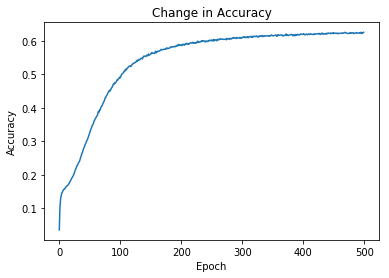

In [43]:
plt.plot(range(epochs),acc_plt)
plt.title("Change in Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

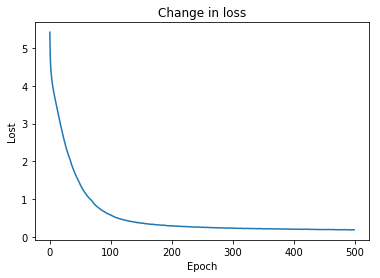

In [44]:
plt.plot(range(epochs),loss_plt)
plt.title("Change in loss")
plt.xlabel('Epoch')
plt.ylabel('Lost')
plt.show()

In [0]:
import pickle

In [0]:
pickle.dump(acc_plt,open('accuracy.p','wb'))

In [0]:
pickle.dump(loss_plt,open('loss.p','wb'))

In [58]:
garbage = []
for code in codes:
  print(vocabs_to_index[code])
  garbage.append(vocabs_to_index[code])

6283
6284
6285
6286


In [0]:
def print_data(i,batch_x,index_to_vocabs):
  data = []
  for n in batch_x[i]:
    if n==garbage[1]:
      break
    else:
      if n not in [6283,6285,6286]:
        data.append(index_to_vocabs[n])
  return data

In [0]:
ques = []
real_answer = []
pred_answer = []
for i in range(len(val_batch_x)):
  ques.append(print_data(i,batch_x,index_to_vocabs))
  real_answer.append(print_data(i,batch_y,index_to_vocabs))
  pred_answer.append(print_data(i,pred,index_to_vocabs))

In [111]:
for i in range(len(val_batch_x)):
    print('row %d'%(i+1))
    print('QUESTION:',' '.join(ques[i]))
    print('REAL ANSWER:',' '.join(real_answer[i]))
    print('PREDICTED ANSWER:',' '.join(pred_answer[i]),'\n')

row 1
QUESTION: something wrong with buttons
REAL ANSWER: buttons are
PREDICTED ANSWER: buttons are 

row 2
QUESTION: i am going this morning
REAL ANSWER: but stoltzfus said
PREDICTED ANSWER: but stoltzfus said 

row 3
QUESTION: but stoltzfus said
REAL ANSWER: i know what he said
PREDICTED ANSWER: i know what he said 

row 4
QUESTION: the bullets
REAL ANSWER: oh the bullets
PREDICTED ANSWER: oh the bullets 

row 5
QUESTION: when will you be going
REAL ANSWER: not long a few days
PREDICTED ANSWER: not long a few days 

row 6
QUESTION: i know
REAL ANSWER: i was being foolish
PREDICTED ANSWER: she works with she 

row 7
QUESTION: where is my pants
REAL ANSWER: here whenever you want them
PREDICTED ANSWER: here whenever you want them 

row 8
QUESTION: say again
REAL ANSWER: make that
PREDICTED ANSWER: you know 

row 9
QUESTION: did you find him
REAL ANSWER: not yet
PREDICTED ANSWER: not yet 

row 10
QUESTION: everything okay
REAL ANSWER: yes thank you very much
PREDICTED ANSWER: yeah dad i

In [114]:
translate_sentence_2 = 'who am i'
translate_sentence_2 = sentence_to_seq(translate_sentence_2, vocabs_to_index)
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(save_path + '.meta')
    loader.restore(sess, save_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    input_data_len = loaded_graph.get_tensor_by_name('input_len:0')
    target_data_len = loaded_graph.get_tensor_by_name('target_len:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence_2]*batch_size,
                                         input_data_len: [len(translate_sentence_2)]*batch_size,
                                         target_data_len : [5]*batch_size,
                                         keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence_2]))
print('  English Words: {}'.format([index_to_vocabs[i] for i in translate_sentence_2]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in translate_logits]))
print('  French Words: {}'.format(" ".join([index_to_vocabs[i] for i in translate_logits])))

INFO:tensorflow:Restoring parameters from model_weights
Input
  Word Ids:      [145, 108, 23]
  English Words: ['who', 'am', 'i']

Prediction
  Word Ids:      [584, 2113, 6284]
  French Words: doctor livingston <EOS>
